# Time-Resolved THz Spectroscopy

This is a tutorial on how to obtain conductivity values from two-dimensional THz spectroscopy data. The example we are working with is a GaAs wafer at room temperature, pumped by a 35 fs, 800 nm pulse, with the THz probe being acquired in reflection geometry. 

Although this example is in the reflection geometry, the code works for transmission geometry too.

In [2]:

import matplotlib.cm as cm      # For choosing the colorscheme in colorplots
import sys 
import pandas as pd             # 2d data is stored as pandas DataFrames
from tqdm import tqdm           # to estimate the progress of simulations


# Insert path to where you extract the mcgillthz folder to use the package anywhere
sys.path.insert(1,"/Users/rodrigo/Programming/mcgillthz") 
from mcgillthz import *



%matplotlib widget

# GaAs - 400 nm pump, reflection geometry

## Importing Data


The data is expected to be in a pandas DataFrame, where the first column contains the time delays between the thz probe pulse and thz detection line in picoseconds. Subsequent columns contains the THz electric field values at different Pump-Probe delay times.

The column names must be strings, and from the second column onwards, is expected to contain the pump-probe time delays.

The do_fft_2d() function calculates the amplitude and phase of the Fourier transform for all pump-probe time delays. The first column of the returned DataFrams contains the frequency values in THz.


In [3]:
folder = './data/'

file = 'GaAsEref400nm.dat'
ref_data = pd.read_csv(folder+file, sep='\t')       # Import file with pandas
# Renaming columns to be strings with 1 decimal point
pp_delays = ref_data.columns[1:].astype('float')    
columns = pp_delays.astype('str').insert(0, 'times')
ref_data.columns = columns
ref_amp, ref_phase = do_fft_2d(ref_data, window='hann')

file = 'GaAsEpump400nm.dat'
pump_data = pd.read_csv(folder+file, sep='\t')
pump_data.columns = columns
pump_amp, pump_phase = do_fft_2d(pump_data, window='hann')

columns

Index(['times', '-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4',
       '1.6', '1.8', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '10.0',
       '100.0'],
      dtype='object')

We can easily visualize the reference and pumped data at specific pump-probe time delays using the plot_spectrum() function, coupled with the pdnp() function.

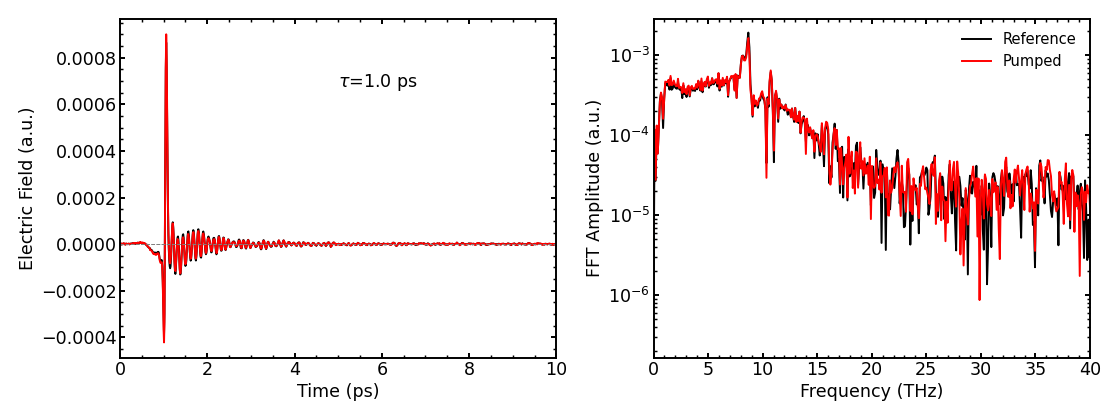

In [4]:

t = '1.0'

axs = plot_spectrum(pdnp(ref_data, t), pdnp(ref_amp, t), color='black', label='Reference', dpi=70)
axs = plot_spectrum(pdnp(pump_data, t), pdnp(pump_amp, t), color='red', label='Pumped', axs=axs)

axs[0].text(0.5, 0.8, fr'$\tau$={t} ps', transform=axs[0].transAxes)

axs[0].set_xlim(0, 10)
axs[1].set_xlim(0, 40)
# axs[1].set_ylim(bottom=1e-3)


plt.show()

## Getting Reflection (or transmission)

The get_T_trts() function calculates the amplitude and phase values of the pumped over static fields. Works for experiments both transmission and reflection.

Requires inputing 6 dataframes, as shown below.

In [5]:
R_amp, R_phase = get_T_trts(ref_data, ref_amp, ref_phase, pump_data, pump_amp, pump_phase, freqs_for_fit=[3,6])


They can be visualized with:
- plot_transmission_trts() - allows for visualization of one time delay at a time
- plot_transmission_slider() - Plots with an iterative slider that allows for quickly changing the pump-probe time delay.
- interpolate_color_mesh() - Makes a linear interpolation between different pump probe time delays, and plots the resulting transmission in a pseudo-color map.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


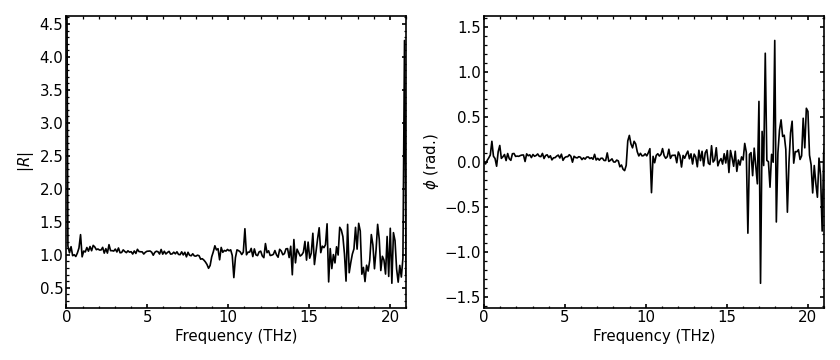

In [6]:
time = '1.0'

axs = plot_transmission_trts(R_amp, R_phase, time, xlim=[0, 21], reflection=True)

SelectionSlider(description='tau (ps)', options=('-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4…

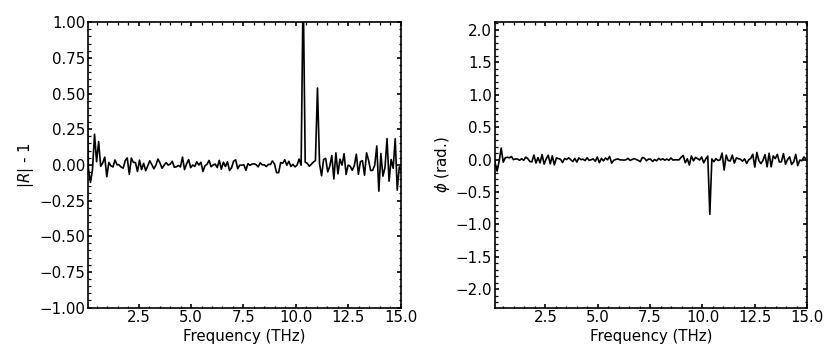

In [9]:
sld, fig, axs = plot_transmission_slider(R_amp, R_phase, color='black', fix_y=True, linestyle='-', xlim=[0.1,15], reflection=True, sub_one=True)

axs[0].set_ylim(-1, 1)


sld

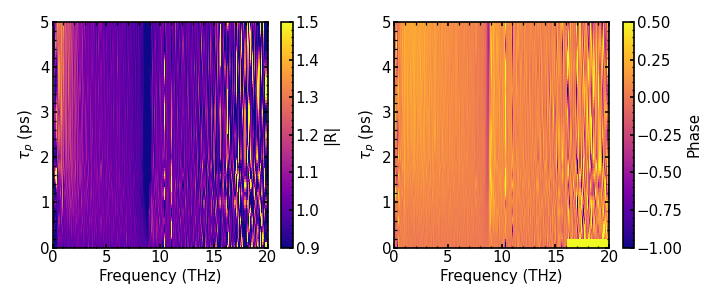

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

im = interpolate_color_mesh(R_amp, axs[0], N=5, max_tau=5, cmap=cm.plasma, xmax=20, vmin=0.9, vmax=1.5)
fig.colorbar(im, ax=axs[0], label='|R|')

im = interpolate_color_mesh(R_phase, axs[1], N=5, max_tau=5, cmap=cm.plasma, xmax=20, vmin=-1, vmax=.5)
fig.colorbar(im, ax=axs[1], label='Phase')



for a in axs:
    a.set_xlim(0, 20)
    a.set_ylim(0, 5)

    a.set_xlabel('Frequency (THz)')
    a.set_ylabel(r'$\tau_p$ (ps)')





## Static dielectric function

Most transmission and reflection models require the sample's index of refraction in equilibrium, so the static unpumped conductivity must be provided

For GaAs, there is only one phonon in the frequency range of interest, so the dielectric function can be obtained from the equation below:

$$ \epsilon(\omega) = \epsilon_\infty  +  \frac{(\epsilon_s - \epsilon_\infty) \omega_{TO}^2}{\omega_{TO}^2 - \omega^2 - i \gamma_{TO} \omega}$$

where the low frequency dielectric function is $\epsilon_s = 3.59^2$, the phonon frequency is $\omega_{TO}= 2\pi \times 8.04 $ THz, the dampening is $\gamma_{TO}= 2\pi \times 0.03 $ THz, and the very high frequency dielectric function can be obtained by the Lyddane-Sachs-Teller relation, since we know the LO phonon is at $\omega_{LO} = 2\pi \times 8.73$ THz:

$$ \epsilon_\infty = \epsilon_s \frac{\omega_{TO}^2}{\omega_{LO}^2} $$


In [13]:
eps_s = 3.59**2
w_TO = 2*np.pi* 8.04
w_LO = 2*np.pi* 8.73
g_TO = 2*np.pi* 0.03

eps_inf = eps_s * w_TO**2/w_LO**2

def Eps_stat(f, eps_s, w_TO, g_TO, eps_inf):
    w = 2*np.pi*f
    return eps_inf + ( eps_s - eps_inf )*w_TO**2 / ( w_TO**2 - w**2  - 1j*g_TO*w_TO  )

After defining the function, define a frequency range, calculate the static dielectric function, and the convert it to the static conductivity. You can use the sig_from_eps() function

<Axes: xlabel='Frequency (THz)', ylabel='$\\tilde{\\epsilon}$'>

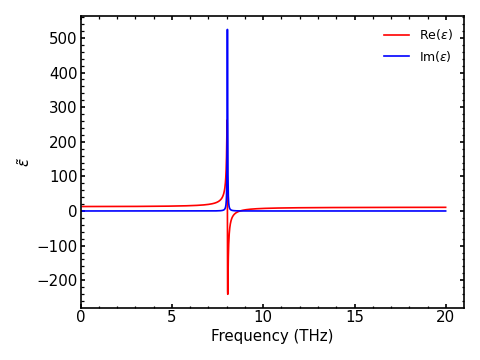

In [14]:
freqs = np.arange(0.1, 20, 0.01)
eps_stat = Eps_stat(freqs, eps_s, w_TO, g_TO, eps_inf)

plot_eps(freqs, eps_stat)


<Axes: xlabel='Frequency (THz)', ylabel='$\\tilde{\\sigma}$ ($10^4$ S/m)'>

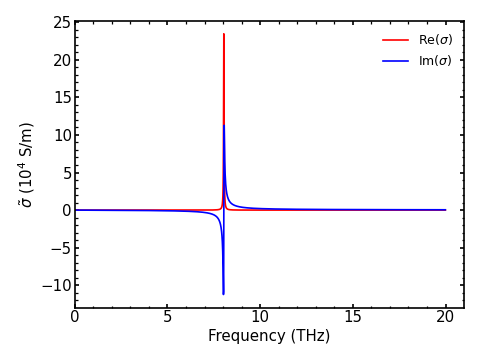

In [15]:
sig_stat = sig_from_eps(eps_stat, freqs, eps_inf)

plot_sigma(freqs, sig_stat, norm=1e4)

<Axes: xlabel='Frequency (THz)', ylabel='$\\tilde{n}$'>

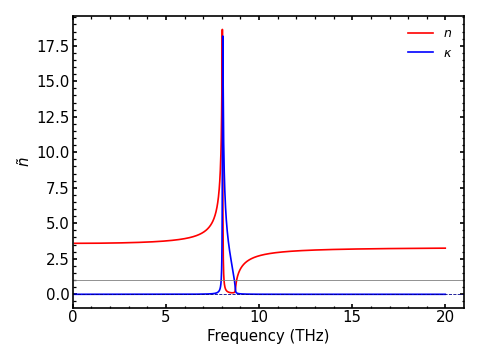

In [16]:
n_stat = n_from_eps(eps_stat)


plot_n_til(freqs, n_stat)

## Tinkham Approximation

Before we jump into more sophisticated models, it is helpful to use a simple approximation like the one first employed by Tinkham. It assumes a very thin homogeneously excited layer, with thickness equal to the penetration depth $1/\alpha$, where $\alpha$ is the absorption coefficient at the pump wavelength.

For reflection geometry, the Tinkham equation is

$$ R = \left( \frac{1 - \tilde{n}_{sub} - Z_0 \tilde{\sigma}d}{1 + \tilde{n}_{sub} + Z_0 \tilde{\sigma}d} \right)  \frac{1 + \tilde{n}_{sub}}{1 - \tilde{n}_{sub}}$$

This can be inverted to yield

$$ \tilde{\sigma} (\omega) = \frac{1}{Z_0 d} \frac{(1-\tilde{n}_{sub}^2)(1 - R)}{(1+R) + \tilde{n}_{sub}(1-R)} $$

where $n_{sub}$ is the equilibrium refractive index of the substrate (or the unpumped GaAs layes in this case).

This can be calculated easily for all time-delays with the sig_tinkham_all() function, using the reflection=True tag.

In [17]:

alpha = 1/100e-9

In [18]:
d = 1/alpha

n_stat_freq = np.sqrt(Eps_stat(R_amp['freq'], eps_s, w_TO, g_TO, eps_inf))

sigs_tink = sig_tinkham_all(R_amp, R_phase, d, n_stat_freq, reflection=True)

The conductivity can be visualized with an iterative slider bar using the plot_complex_slider() function. By default, the real part is plotted in red, and the imaginary in blue.

SelectionSlider(description='tau (ps)', options=('-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4…

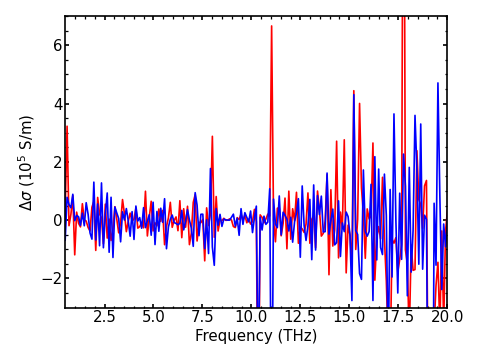

In [19]:
fig, ax = plt.subplots()

sld = plot_complex_slider(sigs_tink, fig, ax, fix_y=True, norm=1e4, ylabel=r'$\Delta \sigma$ ($10^5$ S/m)')#, add_array=sig_static_for_tink)

ax.set_xlim(0.5, 20)

ax.set_ylim(-3, 7)

sld


## Defining the model - Transfer Matrices

Now, we need to define a model to simulate the reflection or transmission. The function input parameters are respectivelly:

- Photoconductivity. (Required)
- Frequency, in THz. (Required)
- Equilibrium conductivity. (Required)
- Model dependent paremeters. (Optional)

The function must output two values: the amplitude and phase of the reflection (or transmission) coefficient. These will be numerically matched to the experimental values, in order to find what the conductivity is.


We can calculate the reflection using a transfer matrix approach. Assuming one photoexcited layer of thickness $d = 1/\alpha$, the transfer matrix of that layer is

$$ M =  \begin{pmatrix}
cos(k d n) & -i/n sin(k d n) \\
-i n sin(k d n) & cos(k d n)
\end{pmatrix} =

\begin{pmatrix}
A & B \\
C & D
\end{pmatrix}
$$

Then, the reflection coefficient is obtained as

$$ r =  \frac{(A + B n_{sub})n_0 - C - D n_{sub}}{(A + B n_{sub})n_0 + C + D n_{sub}}$$

where $n_{sub}$ is the substrate refractive index, which in this case is the equilibrium GaAs index, $n_0$ is the incoming index, which in this case is air ($n_0=1$), and $k$ is the vacuum wavevector.

This is a very simple case with 1 layer. More complex models with several layers can be used instead, and np.matmul() can be used to numerically calculate the matrix multiplication.

In [ ]:
def M(k, d, n_til):
    return np.array([[np.cos(k*d * n_til),    -1j * np.sin(k*d*n_til)/n_til ], 
                    [-1j*n_til*np.sin(k*d*n_til),    np.cos(k*d*n_til)]])


def R_onelayer(dsig, freq, sig0, alpha, eps_inf):
    k = 2*np.pi*(freq*1e12)/c
    omega = 2*np.pi*(freq*1e12)
    d = 1/alpha

    n_eq = n_from_sig(sig0, freq, eps_inf=eps_inf)
    n_p = np.sqrt(eps_from_sig(sig0, freq, eps_inf) + 1j*dsig/(eps0 * omega))

    M_p = M(k, d, n_p)
    M_eq = M(k, d, n_eq)

    r_p = (M_p[0,0] + M_p[0,1]*n_eq   - M_p[1,0] - M_p[1,1]*n_eq ) / (M_p[0,0] + M_p[0,1]*n_eq   + M_p[1,0] + M_p[1,1]*n_eq ) 
    r_eq = (M_eq[0,0] + M_eq[0,1]*n_eq   - M_eq[1,0] - M_eq[1,1]*n_eq ) / (M_eq[0,0] + M_eq[0,1]*n_eq   + M_eq[1,0] + M_eq[1,1]*n_eq ) 

    R = r_p/r_eq 

    return np.abs(R), np.angle(R)


## Fitting a sample data

Before we fit to all pump-probe time delays, we fit for only delay to see if the model is behaving as expected. For this, we use the minimize_err_trts() function, where we feed the model we define in the previous cell.

We can visualize the reflection fit and its residuals using the plot_transmission_fit() function

Using Tinkham in reflection as initial guess with d=100 nm, and n_sub=1.00


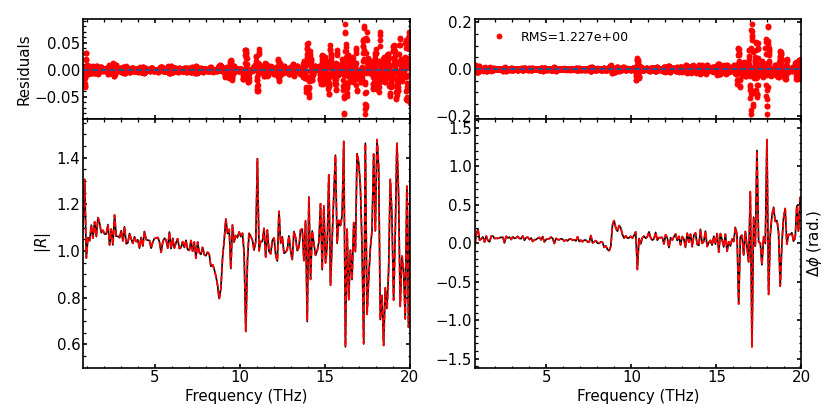

In [ ]:
time = '1.0'
amp = R_amp[time]
phase = R_phase[time]
exp_freqs = R_amp['freq']

dsig0 = 1e5 + 1e5j
alpha = 1/100e-9



dsig_onelayer, amp_fit, phase_fit = minimize_err_trts(dsig0, freqs, R_onelayer, sig_stat, [alpha, eps_inf], amp, phase, \
                                             exp_freqs, method='Powell', start_from='tinkham-ref', bound_offset=1e8)


fig, ax = plot_transmission_fit(exp_freqs, amp, phase, freqs, amp_fit, phase_fit, xlim=[.8, 20], reflection=True)

We can now visualized the photoconductivity, and compare it to the Tinkham case. In this case, they are both very similar, only deviating very close to the resonances.

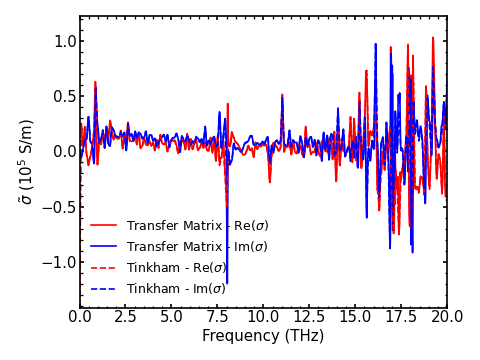

In [ ]:
ax = plot_sigma(freqs, dsig_onelayer, label='Transfer Matrix - ')

ax = plot_sigma(exp_freqs, sig_tinkham(amp, phase, d, n_stat_freq, reflection=True), linestyle='--', label='Tinkham - ', ax=ax)


ax.set_xlim(0, 20)
autoscale_y(ax)

## Fitting all data

Now we fit all the data using the function minimize_err_trts_all(). This usually take a minute or two, so don't worry.

We can visualize all fits with a slider using the plot_transmission_fit_slider() function

In [ ]:
dsig0 = 1e5 + 1e5j
alpha = 1/100e-9

dsig_df, R_fit_amp, R_fit_phase = minimize_err_trts_all(R_amp, R_phase, freqs, R_onelayer, sig_stat, \
                                    [alpha, eps_inf], method='Powell', start_from='tinkham-ref', d_tink=1/alpha, nsub_tink=2, bound_offset=1e5)


 10%|█         | 2/20 [00:11<01:47,  5.95s/it]/Users/rodrigo/Programming/mcgillthz/mcgillthz/trts_analysis.py:133: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(err_func_simp, [np.real(dsig), np.imag(dsig)], method=method, bounds=((-np.real(sig0) - bound_offset,np.infty), (-np.infty, np.infty)))
 15%|█▌        | 3/20 [00:17<01:40,  5.90s/it]/Users/rodrigo/Programming/mcgillthz/mcgillthz/trts_analysis.py:133: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(err_func_simp, [np.real(dsig), np.imag(dsig)], method=method, bounds=((-np.real(sig0) - bound_offset,np.infty), (-np.infty, np.infty)))
 40%|████      | 8/20 [00:48<01:15,  6.31s/it]/Users/rodrigo/Programming/mcgillthz/mcgillthz/trts_analysis.py:133: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(err_func_simp, [np.real(dsig), np.imag(dsig)], method=method, bounds=((-np.real(sig0) - bound_offset,np.infty), (-np.infty, n

SelectionSlider(description='tau (ps)', options=('-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4…

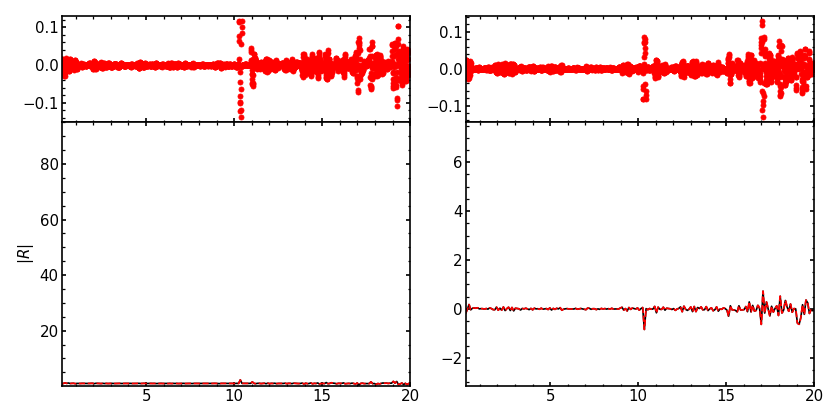

In [ ]:
sl, fig, ax = plot_transmission_fit_slider(R_amp, R_phase, R_fit_amp, R_fit_phase, fix_y=False, xlim=[0.2,20], reflection=True)
sl

## Plotting response functions

To visualized the obtained values with a slider, we can use the plot_complex_slider() function

SelectionSlider(description='tau (ps)', options=('-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4…

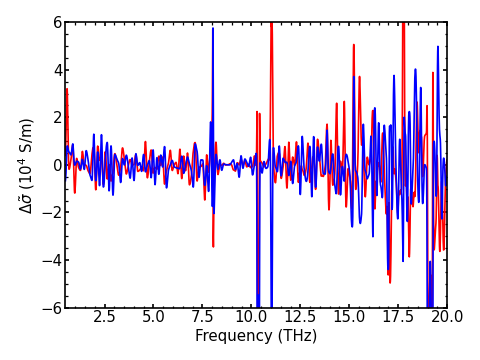

In [ ]:

fig, ax = plt.subplots()

ax.set_xlabel('Frequency (THz)')
ax.set_ylabel(r'$\Delta \tilde{\sigma}$')

ax.set_ylim(-6, 6)

sld = plot_complex_slider(dsig_df , fig, ax, fix_y=True, norm=1e4, ylabel= r'$\Delta \tilde{\sigma}$ ($10^4$ S/m)')

ax.set_xlim(0.5, 20)

sld



You can plot multiple results using the plot_multiple_complex_slider() function. This is useful for comparing with the TInkham approximation.

SelectionSlider(description='tau (ps)', options=('-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4…

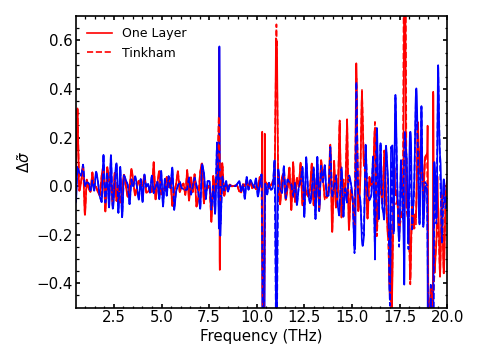

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta \tilde{\sigma}$')

sld = plot_multiple_complex_slider([dsig_df, sigs_tink], fig, ax, ['-', '--'], ['One Layer', 'Tinkham'], fix_y=True, norm=1e5, xlim=[.5,20], plot_tau=False)

ax.set_ylim(-0.5, 0.7)

sld

We can also convert from conductivity to dielectric function using the eps_from_sig_all() function.


SelectionSlider(description='tau (ps)', options=('-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4…

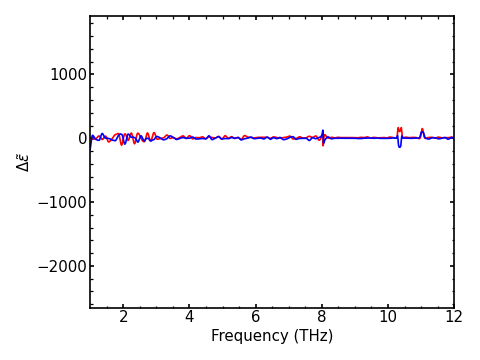

In [ ]:
deps_df = eps_from_sig_all(dsig_df, eps_inf=eps_inf)

fig, ax = plt.subplots()

sld = plot_complex_slider(deps_df , fig, ax, fix_y=True, ylabel= r'$\Delta \tilde{\epsilon}$')

ax.set_xlim(1, 12)

sld


# (EXTRA) Uncertainty Estimation


## Monte Carlo Sampling

We can calculate the conductivity $n$ times for a sample data set, and add a standard error for a parameter $x$ as $\sigma_x = \sigma/\sqrt{n}$, where $\sigma$ is the standard deviation of that variable. Afterwards, we can calculate the mean and standard error of the obtained conductivity. This can be done for any model and any variable.

In the case where the parameters are independent, we can simply add the variance later and obtain the standard deviation of the conductivity:

$$ \sigma_{\Delta \tilde{\sigma}}^2 = \sum_i \sigma_{\Delta \tilde{\sigma}}^2(x_i) , $$

where $\sigma_{\Delta \tilde{\sigma}}^2(x_i) $ is the variance on the conductivity obtained by changing the parameter $x_i$.

We'll reduce the frequency range to be less computationally expensive.

For all, we'll be adding noise with standard deviation equal to 10% of its value.

(1.0, 12.0)

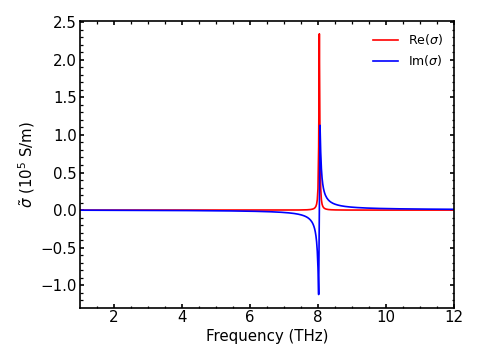

In [ ]:
freqs = np.arange(1, 12, 0.02)
eps_stat = Eps_stat(freqs, eps_s, w_TO, g_TO, eps_inf)

sig_stat = sig_from_eps(eps_stat, freqs, eps_inf)

ax = plot_sigma(freqs, sig_stat, norm=1e5)
ax.set_xlim(1, 12)

Using Tinkham in reflection as initial guess with d=100 nm, and n_sub=1.00


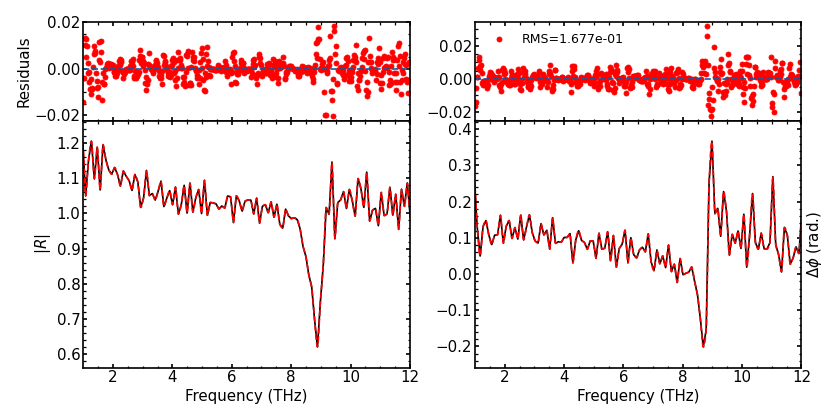

In [ ]:
time = '2.0'
amp = R_amp[time]
phase = R_phase[time]
exp_freqs = R_amp['freq']

dsig0 = 1e5 + 1e5j
alpha = 1/100e-9



dsig, amp_fit, phase_fit = minimize_err_trts(dsig0, freqs, R_onelayer, sig_stat, [alpha, eps_inf], amp, phase, \
                                             exp_freqs, method='Powell', start_from='tinkham-ref', bound_offset=1e8)


fig, ax = plot_transmission_fit(exp_freqs, amp, phase, freqs, amp_fit, phase_fit, xlim=[1, 12], reflection=True)

### Noise to the penetration depth

We perform $n$ fits, where the noise is uniformly distributed with a standard deviation of 10% of the determined value.

In [ ]:
n = 10
sig = 0.1*alpha

alphas = np.random.normal(loc = alpha, scale=sig, size=n)

dsigs_alpha = [[]] * n
for i, a in enumerate(tqdm(alphas)):
    dsigs_alpha[i], _, _ = minimize_err_trts(dsig0, freqs, R_onelayer, sig_stat, [a, eps_inf], \
                                                    amp, phase, exp_freqs, method='Powell', start_from='tinkham-ref', bound_offset=1e8, txt=False)

dsigs_alpha = np.array(dsigs_alpha)
dsig_mean_alpha = np.mean(dsigs_alpha, axis=0)
dsig1_std_alpha = np.std(np.real(dsigs_alpha), axis=0) 
dsig2_std_alpha = np.std(np.imag(dsigs_alpha), axis=0) 



100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


In [ ]:
n_stat_freq = np.sqrt(Eps_stat(R_amp['freq'], eps_s, w_TO, g_TO, eps_inf))


dsigs_alpha_tink = [[]] * n
for i, a in enumerate(alphas):
    dsigs_alpha_tink[i] = sig_tinkham(amp, phase, 1/a, n_stat_freq, reflection=True)



dsigs_alpha_tink = np.array(dsigs_alpha_tink)
dsig_mean_alpha_tink = np.mean(dsigs_alpha_tink, axis=0)
dsig1_std_alpha_tink = np.std(np.real(dsigs_alpha_tink), axis=0) 
dsig2_std_alpha_tink = np.std(np.imag(dsigs_alpha_tink), axis=0) 


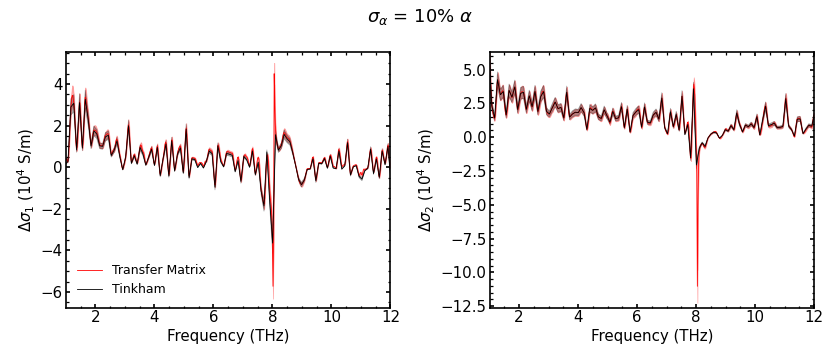

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)

norm = 1e4

axs[0].plot(freqs, np.real(dsig_mean_alpha/norm), color='red', linewidth=1, label='Transfer Matrix')
axs[1].plot(freqs, np.imag(dsig_mean_alpha/norm), color='red', linewidth=1, )

axs[0].fill_between(freqs, (np.real(dsig_mean_alpha) + dsig1_std_alpha)/norm, (np.real(dsig_mean_alpha) - dsig1_std_alpha)/norm, color='red', alpha=.3)
axs[1].fill_between(freqs, (np.imag(dsig_mean_alpha) + dsig2_std_alpha)/norm, (np.imag(dsig_mean_alpha) - dsig2_std_alpha)/norm, color='red', alpha=.3)


axs[0].plot(exp_freqs, np.real(dsig_mean_alpha_tink/norm), color='black', linewidth=1, label='Tinkham')
axs[1].plot(exp_freqs, np.imag(dsig_mean_alpha_tink/norm), color='black', linewidth=1 )

axs[0].fill_between(exp_freqs, (np.real(dsig_mean_alpha_tink) + dsig1_std_alpha_tink)/norm, (np.real(dsig_mean_alpha_tink) - dsig1_std_alpha_tink)/norm, color='black', alpha=.3)
axs[1].fill_between(exp_freqs, (np.imag(dsig_mean_alpha_tink) + dsig2_std_alpha_tink)/norm, (np.imag(dsig_mean_alpha_tink) - dsig2_std_alpha_tink)/norm, color='black', alpha=.3)

axs[0].set_xlim(1, 12)
autoscale_y(axs[0])
autoscale_y(axs[1])

axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'$\Delta \sigma_1$ ($10^4$ S/m)')
axs[1].set_ylabel(r'$\Delta \sigma_2$ ($10^4$ S/m)')

fig.suptitle(r'$\sigma_{\alpha}$ = 10% $\alpha $')

axs[0].legend()


plt.show()

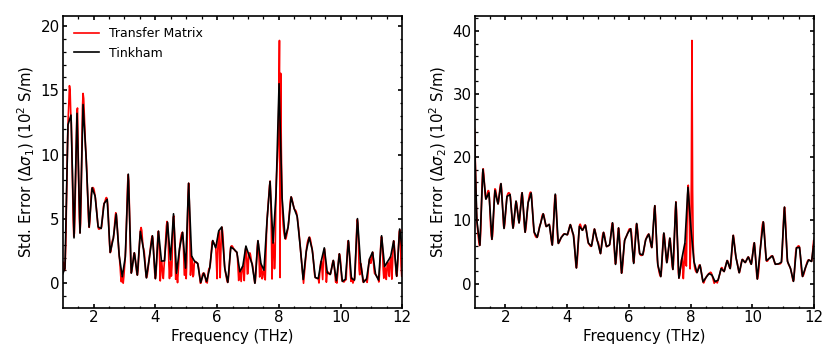

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)

norm = 1e2

axs[0].plot(freqs, dsig1_std_alpha/norm /  np.sqrt(n), color='red', linewidth=2, label='Transfer Matrix')
axs[1].plot(freqs, dsig2_std_alpha/norm/ np.sqrt(n), color='red', linewidth=2, )

axs[0].plot(exp_freqs, dsig1_std_alpha_tink/norm/ np.sqrt(n), color='black', linewidth=2, label='Tinkham')
axs[1].plot(exp_freqs, dsig2_std_alpha_tink/norm/ np.sqrt(n), color='black', linewidth=2 )


axs[0].set_xlim(1, 12)
autoscale_y(axs[0])
autoscale_y(axs[1])

axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'Std. Error ($\Delta \sigma_1$) ($10^2$ S/m)')
axs[1].set_ylabel(r'Std. Error ($\Delta \sigma_2$) ($10^2$ S/m)')

axs[0].legend()

plt.show()

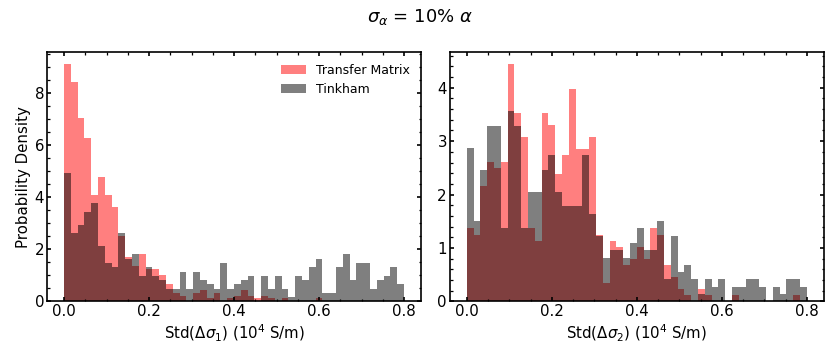

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)

norm=1e4
range_bin = [0,.8]
axs[0].hist(np.abs(dsig1_std_alpha/norm) , bins=50, density=True, range=range_bin, \
            alpha=0.5, color='red', label=f'Transfer Matrix' )
axs[1].hist(np.abs(dsig2_std_alpha/norm) , bins=50, density=True, range=range_bin, \
            alpha=0.5, color='red', label=f'Transfer Matrix')

axs[0].hist(dsig1_std_alpha_tink/norm, bins=50, density=True, range=range_bin, \
            color='black', label='Tinkham', alpha=0.5)
axs[1].hist(dsig2_std_alpha_tink/norm, bins=50, density=True, range=range_bin, \
            color='black', label='Tinkham', alpha=0.5)


# axs[0].set_xlim(1, 12)
# autoscale_y(axs[0])
# autoscale_y(axs[1])

axs[0].set_ylabel('Probability Density')

axs[0].set_xlabel(r'Std($\Delta \sigma_1$) ($10^4$ S/m)')
axs[1].set_xlabel(r'Std($\Delta \sigma_2$) ($10^4$ S/m)')

fig.suptitle(r'$\sigma_{\alpha}$ = 10% $\alpha $')

axs[0].legend()

plt.show()

### Noise to $\epsilon_\infty$

Same can be done for every model parameter

In [ ]:
n = 10
sig = 0.1*eps_inf

eps_infs = np.random.normal(loc = eps_inf, scale=sig, size=n)

dsigs_epsinf = [[]] * n
for i, eps in enumerate(tqdm(eps_infs)):
    eps_s_it = eps * w_LO**2/w_TO**2
    eps_stat = Eps_stat(freqs, eps_s_it, w_TO, g_TO, eps)
    sig_stat = sig_from_eps(eps_stat, freqs, eps)  

    dsigs_epsinf[i], _, _ = minimize_err_trts(dsig0, freqs, R_onelayer, sig_stat, [alpha, eps], \
                                                    amp, phase, exp_freqs, method='Powell', start_from='tinkham-ref', bound_offset=1e8, txt=False)

dsigs_epsinf = np.array(dsigs_epsinf)
dsig_mean_epsinf = np.mean(dsigs_epsinf, axis=0)
dsig1_std_epsinf = np.std(np.real(dsigs_epsinf), axis=0) 
dsig2_std_epsinf = np.std(np.imag(dsigs_epsinf), axis=0) 



100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


In [ ]:

dsigs_epsinf_tink = [[]] * n
for i, eps in enumerate(tqdm(eps_infs)):
    eps_s_it = eps * w_LO**2/w_TO**2
    eps_stat = Eps_stat(exp_freqs, eps_s_it, w_TO, g_TO, eps)
    n_epsinf = np.sqrt(eps_stat)

    dsigs_epsinf_tink[i] = sig_tinkham(amp, phase, 1/alpha, n_epsinf, reflection=True)

dsigs_epsinf_tink = np.array(dsigs_epsinf_tink)
dsig_mean_epsinf_tink = np.mean(dsigs_epsinf_tink, axis=0)
dsig1_std_epsinf_tink = np.std(np.real(dsigs_epsinf_tink), axis=0) 
dsig2_std_epsinf_tink = np.std(np.imag(dsigs_epsinf_tink), axis=0) 


100%|██████████| 10/10 [00:00<00:00, 1298.71it/s]


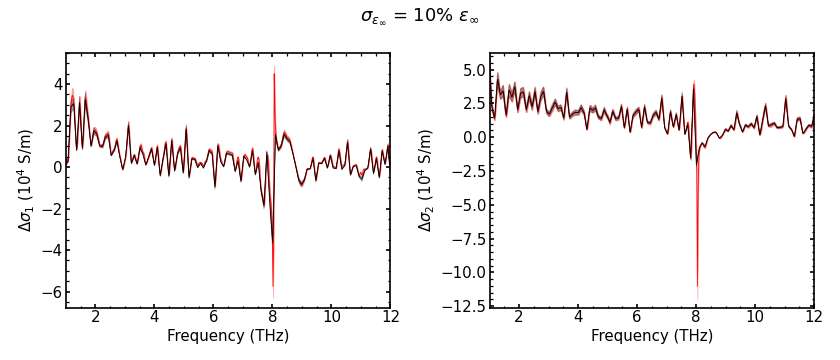

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)

norm = 1e4

axs[0].plot(freqs, np.real(dsig_mean_epsinf/norm), color='red', linewidth=1, label='Transfer Matrix')
axs[1].plot(freqs, np.imag(dsig_mean_epsinf/norm), color='red', linewidth=1, )

axs[0].fill_between(freqs, (np.real(dsig_mean_epsinf) + dsig1_std_epsinf)/norm, (np.real(dsig_mean_epsinf) - dsig1_std_epsinf)/norm, color='red', alpha=.3)
axs[1].fill_between(freqs, (np.imag(dsig_mean_epsinf) + dsig2_std_epsinf)/norm, (np.imag(dsig_mean_epsinf) - dsig2_std_epsinf)/norm, color='red', alpha=.3)


axs[0].plot(exp_freqs, np.real(dsig_mean_epsinf_tink/norm), color='black', linewidth=1, label='Tinkham')
axs[1].plot(exp_freqs, np.imag(dsig_mean_epsinf_tink/norm), color='black', linewidth=1 )

axs[0].fill_between(exp_freqs, (np.real(dsig_mean_epsinf_tink) + dsig1_std_epsinf_tink)/norm, (np.real(dsig_mean_epsinf_tink) - dsig1_std_epsinf_tink)/norm, color='black', alpha=.3)
axs[1].fill_between(exp_freqs, (np.imag(dsig_mean_epsinf_tink) + dsig2_std_epsinf_tink)/norm, (np.imag(dsig_mean_epsinf_tink) - dsig2_std_epsinf_tink)/norm, color='black', alpha=.3)

axs[0].set_xlim(1, 12)
autoscale_y(axs[0])
autoscale_y(axs[1])

axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'$\Delta \sigma_1$ ($10^4$ S/m)')
axs[1].set_ylabel(r'$\Delta \sigma_2$ ($10^4$ S/m)')

fig.suptitle(r'$\sigma_{\epsilon_\infty}$ = 10% $\epsilon_\infty $')

plt.show()

/var/folders/py/sns9zwg579x8c1pf_ptcggqm0000gn/T/ipykernel_96779/2584689866.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)


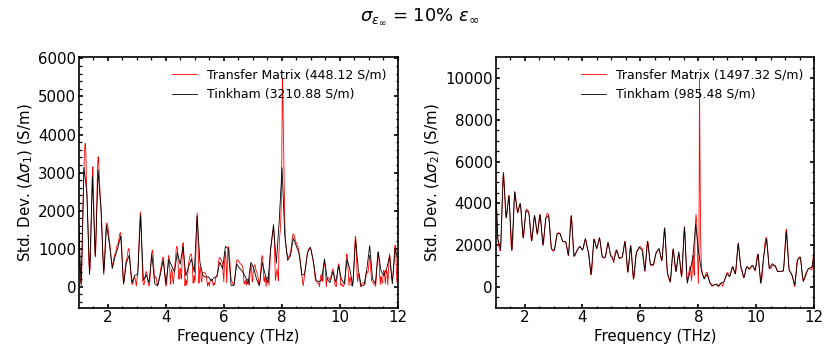

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)

axs[0].plot(freqs, dsig1_std_epsinf , color='red', linewidth=1, \
            label=f'Transfer Matrix ({np.median(dsig1_std_epsinf):.2f} S/m)')
axs[1].plot(freqs, dsig2_std_epsinf , color='red', linewidth=1, \
            label=f'Transfer Matrix ({np.median(dsig2_std_epsinf):.2f} S/m)')

axs[0].plot(exp_freqs, dsig1_std_epsinf_tink , color='black', linewidth=1, \
            label=f'Tinkham ({np.median(dsig1_std_epsinf_tink):.2f} S/m)')
axs[1].plot(exp_freqs, dsig2_std_epsinf_tink , color='black', linewidth=1, \
            label=f'Tinkham ({np.median(dsig2_std_epsinf_tink):.2f} S/m)')

axs[0].set_xlim(1, 12)
autoscale_y(axs[0])
autoscale_y(axs[1])

axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'Std. Dev. ($\Delta \sigma_1$) (S/m)')
axs[1].set_ylabel(r'Std. Dev. ($\Delta \sigma_2$) (S/m)')

axs[0].legend()
axs[1].legend()

fig.suptitle(r'$\sigma_{\epsilon_\infty}$ = 10% $\epsilon_\infty $')

plt.show()

### Adding noise to the background conductivity

In [ ]:
n = 10
sig = 0.1


dsigs_signoise = [[]] * n
for i in tqdm(range(n)):

    dsigs_signoise[i], _, _ = minimize_err_trts(dsig0, freqs, R_onelayer, sig_stat*np.random.normal(loc=1, scale=0.1, size=1), \
                                [alpha, eps_inf], amp, phase, exp_freqs, method='Powell', start_from='tinkham-ref', bound_offset=1e8, txt=False)

dsigs_signoise = np.array(dsigs_signoise)
dsig_mean_signoise = np.mean(dsigs_signoise, axis=0)
dsig1_std_signoise = np.std(np.real(dsigs_signoise), axis=0) 
dsig2_std_signoise = np.std(np.imag(dsigs_signoise), axis=0) 



100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


In [ ]:
inds = ((exp_freqs>np.min(freqs)) & (exp_freqs<np.max(freqs)) ) 

sig_stat_expfreqs = sig_from_eps(eps_stat[inds], exp_freqs[inds], eps_inf)



dsigs_signoise_tink = [[]] * n
for i in tqdm(range(n)):
    n_signoise = n_from_sig(sig_stat_expfreqs*np.random.normal(loc=1, scale=0.1, size=1)[0], exp_freqs[inds], eps_inf)

    dsigs_signoise_tink[i] = sig_tinkham(amp[inds], phase[inds], 1/alpha, n_signoise, reflection=True)

dsigs_signoise_tink = np.array(dsigs_signoise_tink)
dsig_mean_signoise_tink = np.mean(dsigs_signoise_tink, axis=0)
dsig1_std_signoise_tink = np.std(np.real(dsigs_signoise_tink), axis=0) 
dsig2_std_signoise_tink = np.std(np.imag(dsigs_signoise_tink), axis=0) 


100%|██████████| 10/10 [00:00<00:00, 1529.99it/s]


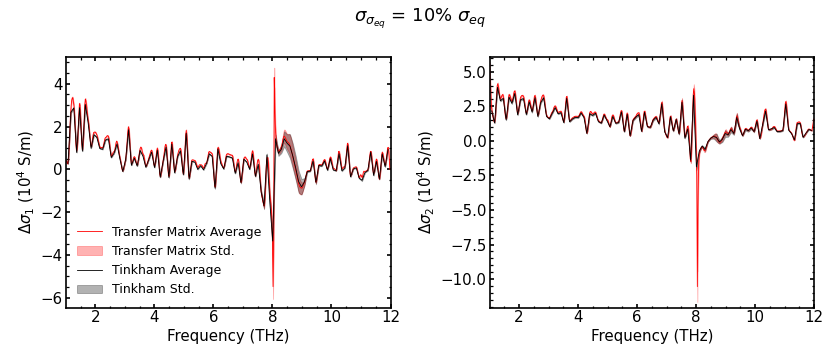

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)

norm = 1e4

axs[0].plot(freqs, np.real(dsig_mean_signoise/norm), color='red', linewidth=1, label='Transfer Matrix Average')
axs[1].plot(freqs, np.imag(dsig_mean_signoise/norm), color='red', linewidth=1, )

axs[0].fill_between(freqs, (np.real(dsig_mean_signoise) + dsig1_std_signoise)/norm, (np.real(dsig_mean_signoise) - dsig1_std_signoise)/norm, color='red', alpha=.3, label='Transfer Matrix Std.')
axs[1].fill_between(freqs, (np.imag(dsig_mean_signoise) + dsig2_std_signoise)/norm, (np.imag(dsig_mean_signoise) - dsig2_std_signoise)/norm, color='red', alpha=.3)


axs[0].plot(exp_freqs[inds], np.real(dsig_mean_signoise_tink/norm), color='black', linewidth=1, label='Tinkham Average')
axs[1].plot(exp_freqs[inds], np.imag(dsig_mean_signoise_tink/norm), color='black', linewidth=1 )

axs[0].fill_between(exp_freqs[inds], (np.real(dsig_mean_signoise_tink) + dsig1_std_signoise_tink)/norm, (np.real(dsig_mean_signoise_tink) - dsig1_std_signoise_tink)/norm, color='black', alpha=.3, label='Tinkham Std.')
axs[1].fill_between(exp_freqs[inds], (np.imag(dsig_mean_signoise_tink) + dsig2_std_signoise_tink)/norm, (np.imag(dsig_mean_signoise_tink) - dsig2_std_signoise_tink)/norm, color='black', alpha=.3)

axs[0].set_xlim(1, 12)
autoscale_y(axs[0])
autoscale_y(axs[1])

axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'$\Delta \sigma_1$ ($10^4$ S/m)')
axs[1].set_ylabel(r'$\Delta \sigma_2$ ($10^4$ S/m)')

fig.suptitle(r'$\sigma_{\sigma_{eq}}}$ = 10% $\sigma_{eq} $')


axs[0].legend()

plt.show()

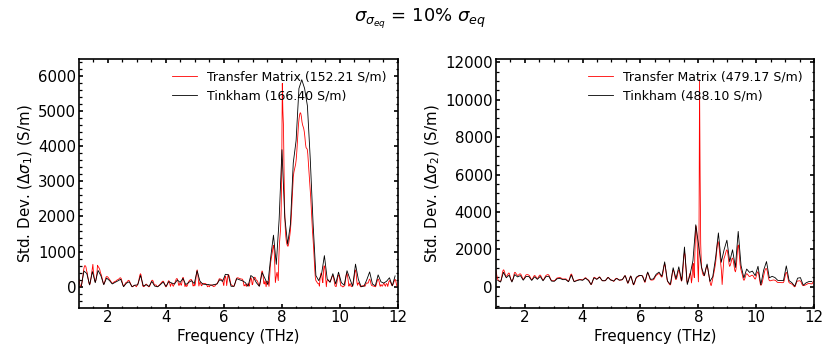

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)


axs[0].plot(freqs, dsig1_std_signoise , color='red', linewidth=1, \
            label=f'Transfer Matrix ({np.median(dsig1_std_signoise):.2f} S/m)')
axs[1].plot(freqs, dsig2_std_signoise , color='red', linewidth=1, \
            label=f'Transfer Matrix ({np.median(dsig2_std_signoise):.2f} S/m)')

axs[0].plot(exp_freqs[inds], dsig1_std_signoise_tink , color='black', linewidth=1, \
            label=f'Tinkham ({np.median(dsig1_std_signoise_tink):.2f} S/m)')
axs[1].plot(exp_freqs[inds], dsig2_std_signoise_tink , color='black', linewidth=1, \
            label=f'Tinkham ({np.median(dsig2_std_signoise_tink):.2f} S/m)')


axs[0].set_xlim(1, 12)
autoscale_y(axs[0])
autoscale_y(axs[1])

axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'Std. Dev. ($\Delta \sigma_1$) (S/m)')
axs[1].set_ylabel(r'Std. Dev. ($\Delta \sigma_2$) (S/m)')

axs[0].legend()
axs[1].legend()

fig.suptitle(r'$\sigma_{\sigma_{eq}}}$ = 10% $ \sigma_{eq} $')

plt.show()

## Latin Hypercube Sampling

Now, suppose we know that the parameters of the model are not independent, meaning we can't simply add their contribution to the variance of the conductivity. In this case, we can do Latin Hypercube Sampling (LHS), as it ensures that the entire range of each parameter is sampled more efficiently compared to simple random sampling.

We have to 

- Divide the Range: Divide the range of each parameter into N equally probable intervals.
- Sample Without Replacement: For each parameter, sample one value from each interval without replacement.
- Combine Samples: Randomly combine the sampled values for all parameters to create N sets of parameter values.


Now, let's assume that the parameters we have are

- $1/\alpha = 100 \pm 10$ nm
- $\epsilon_\infty = 10.93 \pm 1$
- $\omega_{LO} = 8.73 \pm 0.10$ THz

In [ ]:
def lhs_sampling(param_ranges, N):
    num_params = len(param_ranges)
    lhs_samples = np.zeros((N, num_params))
    
    for i in range(num_params):
        intervals = np.linspace(param_ranges[i][0], param_ranges[i][1], N + 1)
        lhs_samples[:, i] = np.random.uniform(intervals[:-1], intervals[1:], size=N)
        np.random.shuffle(lhs_samples[:, i])
    
    return lhs_samples

# Define the range of the parameters
param_ranges = [(1/110e-9, 1/90e-9), (9.93, 11.93), (2*np.pi*8.63, 2*np.pi*8.83)]


# Number of samples
N = 200

# Generate LHS samples of the parameters
lhs_samples = lhs_sampling(param_ranges, N)

In [ ]:
# Define frequencies that are fine only around the sharp features.
freqs = np.concatenate((np.arange(1, 7, 0.1) ,  np.arange(7, 10, 0.02), np.arange(10, 12, 0.1)))

# Now we only have to feed them into the model
dsigs_lhs = [[]] * N
for i, (alpha_i, eps_inf_i, w_LO_i) in enumerate(tqdm(lhs_samples)):
    eps_s_it = eps_inf_i * w_LO_i**2/w_TO**2
    eps_stat = Eps_stat(freqs, eps_s_it, w_TO, g_TO, eps_inf_i)
    sig_stat = sig_from_eps(eps_stat, freqs, eps_inf_i)  

    dsigs_lhs[i], _, _ = minimize_err_trts(dsig0, freqs, R_onelayer, sig_stat, [alpha_i, eps_inf_i], \
                                                    amp, phase, exp_freqs, method='Powell', start_from='tinkham-ref', bound_offset=1e8, txt=False)

dsigs_lhs = np.array(dsigs_lhs)
dsig_mean_lhs = np.mean(dsigs_lhs, axis=0)
dsig1_std_lhs = np.std(np.real(dsigs_lhs), axis=0) 
dsig2_std_lhs = np.std(np.imag(dsigs_lhs), axis=0) 

# freqs

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


In [ ]:
# Doing Tinkham

inds = ((exp_freqs>np.min(freqs)) & (exp_freqs<np.max(freqs)) ) 

dsigs_lhs_tink = [[]] * N
for i, (alpha_i, eps_inf_i, w_LO_i) in enumerate(tqdm(lhs_samples)):
    eps_s_it = eps_inf_i * w_LO_i**2/w_TO**2
    eps_stat = Eps_stat(exp_freqs[inds], eps_s_it, w_TO, g_TO, eps_inf_i)
    n_stat_i = np.sqrt(eps_stat)

    dsigs_lhs_tink[i] = sig_tinkham(amp[inds], phase[inds], 1/alpha_i, n_stat_i, reflection=True)

dsigs_lhs_tink = np.array(dsigs_lhs_tink)
dsig_mean_lhs_tink = np.mean(dsigs_lhs_tink, axis=0)
dsig1_std_lhs_tink = np.std(np.real(dsigs_lhs_tink), axis=0) 
dsig2_std_lhs_tink = np.std(np.imag(dsigs_lhs_tink), axis=0) 

# freqs

100%|██████████| 200/200 [00:00<00:00, 1110.79it/s]


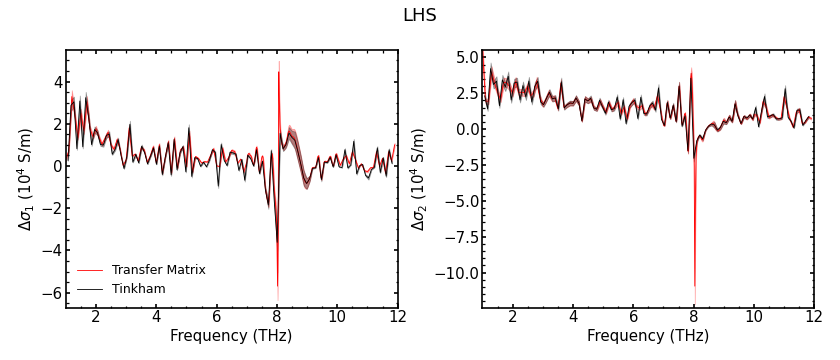

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)

norm = 1e4

axs[0].plot(freqs, np.real(dsig_mean_lhs/norm), color='red', linewidth=1, label='Transfer Matrix')
axs[1].plot(freqs, np.imag(dsig_mean_lhs/norm), color='red', linewidth=1, )

axs[0].fill_between(freqs, (np.real(dsig_mean_lhs) + dsig1_std_lhs)/norm, (np.real(dsig_mean_lhs) - dsig1_std_lhs)/norm, color='red', alpha=.3)
axs[1].fill_between(freqs, (np.imag(dsig_mean_lhs) + dsig2_std_lhs)/norm, (np.imag(dsig_mean_lhs) - dsig2_std_lhs)/norm, color='red', alpha=.3)


axs[0].plot(exp_freqs[inds], np.real(dsig_mean_lhs_tink/norm), color='black', linewidth=1, label='Tinkham')
axs[1].plot(exp_freqs[inds], np.imag(dsig_mean_lhs_tink/norm), color='black', linewidth=1 )

axs[0].fill_between(exp_freqs[inds], (np.real(dsig_mean_lhs_tink) + dsig1_std_lhs_tink)/norm, (np.real(dsig_mean_lhs_tink) - dsig1_std_lhs_tink)/norm, color='black', alpha=.3)
axs[1].fill_between(exp_freqs[inds], (np.imag(dsig_mean_lhs_tink) + dsig2_std_lhs_tink)/norm, (np.imag(dsig_mean_lhs_tink) - dsig2_std_lhs_tink)/norm, color='black', alpha=.3)

axs[0].set_xlim(1, 12)
autoscale_y(axs[0])
autoscale_y(axs[1])

axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'$\Delta \sigma_1$ ($10^4$ S/m)')
axs[1].set_ylabel(r'$\Delta \sigma_2$ ($10^4$ S/m)')

axs[0].legend(loc='lower left')

fig.suptitle(r'LHS')


plt.show()

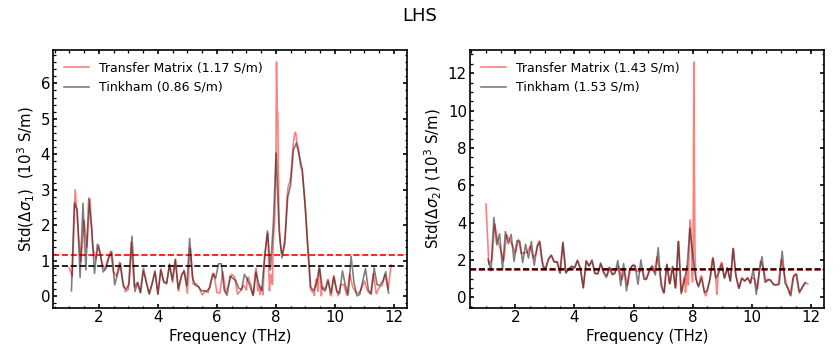

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharex=True)


range_bin = [0,5]
norm = 1e3
mean_std1 = np.mean(np.abs(dsig1_std_lhs/norm))
mean_std2 = np.mean(np.abs(dsig2_std_lhs/norm))
axs[0].plot(freqs, dsig1_std_lhs/norm, \
            alpha=0.5, color='red', label=f'Transfer Matrix ({mean_std1:.2f} S/m)' )
axs[1].plot(freqs, dsig2_std_lhs/norm , \
            alpha=0.5, color='red', label=f'Transfer Matrix ({mean_std2:.2f} S/m)')


axs[0].axhline(mean_std1, color='red', linestyle='--')
axs[1].axhline(mean_std2, color='red', linestyle='--')


mean_std1_tink = np.mean(np.abs(dsig1_std_lhs_tink/norm))
mean_std2_tink = np.mean(np.abs(dsig2_std_lhs_tink/norm))
axs[0].plot(exp_freqs[inds], dsig1_std_lhs_tink/norm , \
            alpha=0.5, color='black', label=f'Tinkham ({mean_std1_tink:.2f} S/m)' )
axs[1].plot(exp_freqs[inds], dsig2_std_lhs_tink/norm ,  \
            alpha=0.5, color='black', label=f'Tinkham ({mean_std2_tink:.2f} S/m)')

axs[0].axhline(mean_std1_tink, color='black', linestyle='--')
axs[1].axhline(mean_std2_tink, color='black', linestyle='--')


axs[0].set_xlabel('Frequency (THz)')
axs[1].set_xlabel('Frequency (THz)')

axs[0].set_ylabel(r'Std($\Delta \sigma_1$)  ($10^3$ S/m)')
axs[1].set_ylabel(r'Std($\Delta \sigma_2$) ($10^3$ S/m)')

fig.suptitle(r'LHS')

axs[0].legend()
axs[1].legend()


plt.show()

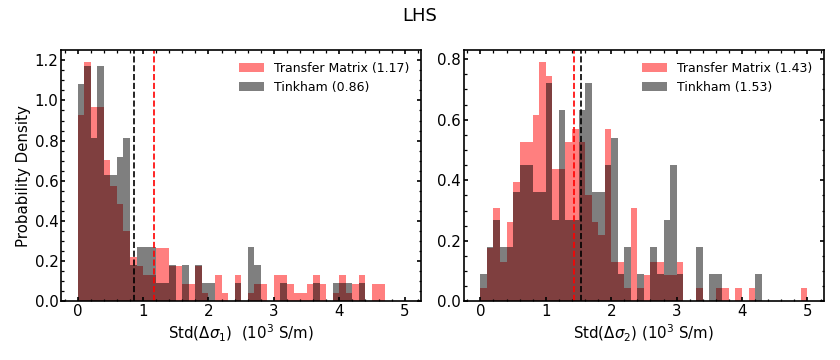

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))


range_bin = [0,5]
norm = 1e3
mean_std1 = np.mean(np.abs(dsig1_std_lhs/norm))
mean_std2 = np.mean(np.abs(dsig2_std_lhs/norm))
axs[0].hist(dsig1_std_lhs/norm , bins=50, density=True, range=range_bin, \
            alpha=0.5, color='red', label=f'Transfer Matrix ({mean_std1:.2f})' )
axs[1].hist(dsig2_std_lhs/norm , bins=50, density=True, range=range_bin, \
            alpha=0.5, color='red', label=f'Transfer Matrix ({mean_std2:.2f})')


axs[0].axvline(mean_std1, color='red', linestyle='--')
axs[1].axvline(mean_std2, color='red', linestyle='--')


mean_std1_tink = np.mean(np.abs(dsig1_std_lhs_tink/norm))
mean_std2_tink = np.mean(np.abs(dsig2_std_lhs_tink/norm))
axs[0].hist(dsig1_std_lhs_tink/norm , bins=50, density=True, range=range_bin, \
            alpha=0.5, color='black', label=f'Tinkham ({mean_std1_tink:.2f})' )
axs[1].hist(dsig2_std_lhs_tink/norm , bins=50, density=True, range=range_bin, \
            alpha=0.5, color='black', label=f'Tinkham ({mean_std2_tink:.2f})')

axs[0].axvline(mean_std1_tink, color='black', linestyle='--')
axs[1].axvline(mean_std2_tink, color='black', linestyle='--')



axs[0].set_ylabel('Probability Density')

axs[0].set_xlabel(r'Std($\Delta \sigma_1$)  ($10^3$ S/m)')
axs[1].set_xlabel(r'Std($\Delta \sigma_2$) ($10^3$ S/m)')

fig.suptitle(r'LHS')

axs[0].legend()
axs[1].legend()


plt.show()